In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

<br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 304)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [21]:
class MLP() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    
    def build(self, batch_size, input_dim, output_dim, num_layer, num_unit, activation) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            # input  : ? x input_length x input_dim
            self.X = tf.placeholder(tf.float32, [None, input_dim])
            self.Y = tf.placeholder(tf.float32, [None, output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            
            self.batch_size = batch_size
            self.output_dim = output_dim
            self.num_layer = num_layer
            self.num_unit = num_unit
            self.activation = activation
            #############
            
            
            ## MLP ##
            layer = tf.layers.dense(self.X, self.num_unit, activation=self.activation)
            
            for idx in range((self.num_layer-2)//2) :
                norm1 = tf.contrib.layers.layer_norm(layer)
                relu1 = tf.nn.relu(norm1)
                layer1 = tf.layers.dense(relu1, self.num_unit)
                
                norm2 = tf.contrib.layers.layer_norm(layer1)
                relu2 = tf.nn.relu(norm2)
                layer2 = tf.layers.dense(relu2, self.num_unit)
                
                layer = tf.layers.dropout(layer2 + layer, training=self.training)
                
            layer = tf.layers.dense(layer, self.output_dim)
            #########################
            
            
            ## Classifier ##
            self.weight = tf.nn.softmax(tf.Variable(tf.random_normal([4])))+tf.ones([4])
            weight_y =  tf.reduce_sum(self.weight * self.Y, axis=1) 
            
            self.logit = layer
            self.softmax = tf.nn.softmax(self.logit)
            self.softmax_logit = tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y)
            self.softmax_logit_weight = self.softmax_logit * weight_y
            ################
            
            
            ## Learning ##
            self.cost = tf.reduce_sum(self.softmax_logit_weight)

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [22]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [23]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 100
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [24]:
idx = 0
model_lst = []

for num_layer in [4,6,8] :
    for num_unit in [256, 512] :
        for activation in [None, tf.nn.relu] :
            print(idx)
            sess = tf.Session()
            model = MLP(sess, "model{}".format(idx))
            model.build(batch_size, input_dim, 4, num_layer, num_unit, activation)
            sess.run(tf.global_variables_initializer())
            
            model_lst.append(model)
            idx+=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [25]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    for model in model_lst :
        print("Weight:", sess.run(model.weight))
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 585.81775(60.6%), valid584.21454(60.9%)
-- train 498.06910(64.2%), valid501.49800(64.4%)
-- train 568.47519(60.1%), valid570.00681(60.1%)
-- train 570.09817(62.4%), valid569.17439(62.7%)
-- train 563.45681(60.5%), valid560.68901(60.6%)
-- train 585.95737(61.7%), valid588.45826(62.0%)
-- train 573.53869(60.2%), valid568.42145(60.8%)
-- train 574.64818(59.9%), valid578.40015(59.8%)
-- train 598.10970(58.4%), valid596.06739(58.3%)
-- train 566.03274(62.1%), valid563.02006(62.6%)
-- train 638.97248(58.7%), valid631.72665(59.0%)
-- train 545.64714(61.7%), valid545.07911(62.0%)
Accuracy: 0.6091000035405159
Accuracy: 0.6444500014185905
Accuracy: 0.601400001347065
Accuracy: 0.6266000017523765
Accuracy: 0.6059499993920326
Accuracy: 0.6200999990105629
Accuracy: 0.6080499961972237
Accuracy: 0.5976999953389

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  5
-- train 535.02302(62.4%), valid548.48073(61.9%)
-- train 474.41196(65.7%), valid514.53449(65.0%)
-- train 3164.22242(51.6%), valid3130.32957(52.3%)
-- train 480.06239(65.3%), valid529.34714(64.8%)
-- train 1449.87145(58.7%), valid1467.98488(58.6%)
-- train 464.59927(65.9%), valid482.72171(65.8%)
-- train 1077.84386(58.1%), valid1069.29728(58.2%)
-- train 514.24616(63.4%), valid572.98126(62.6%)
-- train 663.61534(60.8%), valid671.49430(60.8%)
-- train 547.70143(64.1%), valid588.44116(63.8%)
-- train 1964.78620(57.9%), valid2069.38195(57.7%)
-- train 524.60463(64.9%), valid544.88947(65.0%)
Accuracy: 0.6189499944448471
Accuracy: 0.6500000014901162
Accuracy: 0.5232999995350838
Accuracy: 0.6476999953389168
Accuracy: 0.5863499999046325
Accuracy: 0.6578499972820282
Accuracy: 0.581599996984005
Accuracy: 0.625900000333786
Accuracy

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  10
-- train 478.29579(65.8%), valid520.34165(65.2%)
-- train 397.39447(68.3%), valid444.64958(67.2%)
-- train 599.73776(62.9%), valid628.92468(62.5%)
-- train 414.41672(67.9%), valid460.72609(67.0%)
-- train 558.42292(64.7%), valid579.27750(64.6%)
-- train 420.49468(66.8%), valid445.84642(66.1%)
-- train 881.20544(63.5%), valid945.53334(62.9%)
-- train 445.22051(67.6%), valid523.51474(67.0%)
-- train 660.67511(65.3%), valid686.62943(65.0%)
-- train 465.96074(65.1%), valid511.28949(64.6%)
-- train 1153.83820(62.6%), valid1267.57323(62.2%)
-- train 525.07166(65.6%), valid583.17610(65.2%)
Accuracy: 0.6515500009059906
Accuracy: 0.6724499985575676
Accuracy: 0.6250000029802323
Accuracy: 0.6702000007033349
Accuracy: 0.6463000044226647
Accuracy: 0.6608000010251999
Accuracy: 0.6293499961495399
Accuracy: 0.669650000333786
Accuracy: 0.

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  15
-- train 452.15690(66.3%), valid496.62049(65.7%)
-- train 393.00877(68.8%), valid434.65493(67.4%)
-- train 543.98624(65.8%), valid582.65380(65.7%)
-- train 391.62403(68.8%), valid460.74110(67.3%)
-- train 582.22141(62.6%), valid608.12188(62.2%)
-- train 410.58164(67.5%), valid455.71912(66.8%)
-- train 770.24394(60.3%), valid812.83304(60.3%)
-- train 418.54031(68.3%), valid514.58685(67.5%)
-- train 713.89244(65.4%), valid752.16284(64.9%)
-- train 462.78657(65.2%), valid511.27519(64.9%)
-- train 741.55670(65.4%), valid849.92166(64.7%)
-- train 448.01045(66.7%), valid527.00891(66.3%)
Accuracy: 0.6572999998927116
Accuracy: 0.6740999981760979
Accuracy: 0.6574500009417534
Accuracy: 0.6732499971985817
Accuracy: 0.6215000048279762
Accuracy: 0.667599992454052
Accuracy: 0.602650000154972
Accuracy: 0.6747999966144562
Accuracy: 0.649

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  20
-- train 411.46431(68.4%), valid466.93969(67.1%)
-- train 374.98554(69.7%), valid432.02276(67.9%)
-- train 468.72023(66.9%), valid537.80222(66.5%)
-- train 370.23028(70.2%), valid444.44606(67.9%)
-- train 427.06324(67.7%), valid455.46411(66.8%)
-- train 391.49064(68.6%), valid435.07977(67.7%)
-- train 522.30734(65.8%), valid558.69971(65.8%)
-- train 388.17910(68.9%), valid486.46058(67.8%)
-- train 489.08017(66.7%), valid525.51519(66.2%)
-- train 434.47677(67.0%), valid475.62893(66.6%)
-- train 704.34359(65.8%), valid799.57816(64.9%)
-- train 435.98233(65.4%), valid497.10737(64.9%)
Accuracy: 0.6713500037789345
Accuracy: 0.6791999995708465
Accuracy: 0.6647500023245811
Accuracy: 0.6791999965906144
Accuracy: 0.6677000001072884
Accuracy: 0.677300001680851
Accuracy: 0.6582999989390373
Accuracy: 0.6781499981880188
Accuracy: 0.66

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  25
-- train 406.23853(68.5%), valid464.61392(66.9%)
-- train 366.76397(70.4%), valid439.38926(68.3%)
-- train 442.02271(65.7%), valid504.83050(64.7%)
-- train 361.88468(71.0%), valid461.24874(68.1%)
-- train 416.42990(68.0%), valid452.81087(66.7%)
-- train 388.01697(69.0%), valid438.88336(67.9%)
-- train 529.15583(67.4%), valid594.65596(67.2%)
-- train 380.25767(69.4%), valid481.90149(68.0%)
-- train 520.15129(67.5%), valid572.43484(66.8%)
-- train 426.52470(67.7%), valid469.37467(67.4%)
-- train 527.05292(66.7%), valid594.43170(66.2%)
-- train 419.33951(66.2%), valid496.83069(65.7%)
Accuracy: 0.6690500020980835
Accuracy: 0.6833999946713447
Accuracy: 0.6472500011324882
Accuracy: 0.681149996817112
Accuracy: 0.6674000024795532
Accuracy: 0.6794000014662742
Accuracy: 0.6722000017762184
Accuracy: 0.6801999986171723
Accuracy: 0.66

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  30
-- train 394.03768(69.1%), valid471.34586(66.9%)
-- train 364.50595(70.5%), valid447.39791(68.3%)
-- train 439.22900(68.2%), valid513.21269(67.2%)
-- train 356.01487(71.1%), valid467.28354(68.1%)
-- train 410.20378(68.4%), valid455.56901(67.1%)
-- train 385.44441(69.1%), valid442.93328(67.8%)
-- train 500.27188(67.6%), valid568.45218(66.8%)
-- train 375.10210(69.6%), valid490.15795(67.9%)
-- train 436.62075(67.9%), valid471.34815(67.0%)
-- train 421.07482(67.3%), valid480.73447(66.7%)
-- train 517.38668(67.4%), valid602.96085(66.6%)
-- train 417.97297(66.8%), valid516.90888(66.2%)
Accuracy: 0.6694499969482421
Accuracy: 0.682650001347065
Accuracy: 0.6720000013709069
Accuracy: 0.6806499987840653
Accuracy: 0.6707499980926513
Accuracy: 0.6780999973416328
Accuracy: 0.6678499981760979
Accuracy: 0.6794999986886978
Accuracy: 0.67

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  35
-- train 400.31727(69.6%), valid488.91628(67.3%)
-- train 362.71873(71.0%), valid458.10506(68.6%)
-- train 432.83757(68.8%), valid520.18880(67.6%)
-- train 348.64482(71.5%), valid501.44213(68.2%)
-- train 407.48959(69.1%), valid455.32818(67.7%)
-- train 382.61245(69.1%), valid445.01838(67.5%)
-- train 769.69092(61.8%), valid846.47651(60.8%)
-- train 380.04993(69.6%), valid535.67187(67.9%)
-- train 507.71221(67.5%), valid570.73782(66.6%)
-- train 430.73302(66.3%), valid492.23905(65.8%)
-- train 517.76723(67.4%), valid605.51440(66.5%)
-- train 410.27786(67.5%), valid535.39629(66.4%)
Accuracy: 0.6729500010609627
Accuracy: 0.6855499967932701
Accuracy: 0.676299998164177
Accuracy: 0.6822499975562095
Accuracy: 0.6766000002622604
Accuracy: 0.6750499963760376
Accuracy: 0.6083499982953071
Accuracy: 0.6785499960184097
Accuracy: 0.66

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  40
-- train 379.56093(70.4%), valid476.40755(67.7%)
-- train 358.90848(71.3%), valid469.15599(68.2%)
-- train 449.20269(67.3%), valid547.24674(66.0%)
-- train 345.99767(71.5%), valid502.93825(68.0%)
-- train 402.95000(67.8%), valid461.98781(66.0%)
-- train 382.24989(69.0%), valid447.31593(67.5%)
-- train 472.65147(66.0%), valid562.80744(64.8%)
-- train 377.55076(69.7%), valid508.86613(67.9%)
-- train 430.56465(68.0%), valid471.61666(67.0%)
-- train 411.78421(67.1%), valid466.71001(66.4%)
-- train 523.31421(67.8%), valid649.34811(66.6%)
-- train 412.17442(66.9%), valid521.44246(66.1%)
Accuracy: 0.6765499979257583
Accuracy: 0.6819000005722046
Accuracy: 0.6597000002861023
Accuracy: 0.6796999961137772
Accuracy: 0.6604000017046928
Accuracy: 0.675100003182888
Accuracy: 0.6477999970316887
Accuracy: 0.67865000218153
Accuracy: 0.6704

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  45
-- train 373.26989(70.7%), valid479.09780(67.7%)
-- train 347.71934(71.6%), valid476.71546(68.5%)
-- train 394.26674(69.7%), valid508.61150(67.6%)
-- train 346.15942(71.7%), valid532.21549(67.9%)
-- train 414.21374(68.3%), valid484.49279(66.4%)
-- train 379.41425(69.3%), valid453.95914(67.7%)
-- train 781.97575(63.5%), valid898.68786(63.1%)
-- train 364.30911(70.5%), valid514.68163(67.9%)
-- train 431.13724(68.5%), valid491.77888(67.1%)
-- train 413.47770(66.8%), valid461.21042(65.8%)
-- train 503.47753(67.8%), valid628.45039(66.6%)
-- train 413.82840(66.5%), valid640.55961(65.6%)
Accuracy: 0.6770499974489212
Accuracy: 0.6847000002861023
Accuracy: 0.6760999992489815
Accuracy: 0.6793499976396561
Accuracy: 0.6640499964356422
Accuracy: 0.676850003004074
Accuracy: 0.6312000021338463
Accuracy: 0.6794999971985817
Accuracy: 0.67

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  50
-- train 371.75274(71.1%), valid505.70396(67.5%)
-- train 348.39237(71.9%), valid492.51535(68.4%)
-- train 399.99747(70.0%), valid548.28768(67.5%)
-- train 342.66276(72.0%), valid534.95102(67.8%)
-- train 378.09149(70.0%), valid461.53611(67.8%)
-- train 372.51797(69.7%), valid454.04419(67.9%)
-- train 437.86653(67.7%), valid557.21014(66.4%)
-- train 364.38398(70.5%), valid532.76873(68.0%)
-- train 424.24073(68.0%), valid489.29299(66.5%)
-- train 419.46628(67.4%), valid465.76063(66.8%)
-- train 509.89486(66.5%), valid631.72176(64.9%)
-- train 410.69820(67.4%), valid725.83038(66.6%)
Accuracy: 0.6748999997973442
Accuracy: 0.6835999995470047
Accuracy: 0.6747000008821488
Accuracy: 0.6780999973416328
Accuracy: 0.6783999994397163
Accuracy: 0.6788999989628792
Accuracy: 0.6641000002622605
Accuracy: 0.6803000018000602
Accuracy: 0.6

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  55
-- train 367.96221(70.8%), valid505.73984(67.0%)
-- train 346.92582(71.9%), valid506.71539(68.3%)
-- train 396.45027(70.1%), valid552.01020(66.8%)
-- train 340.48186(72.4%), valid561.36254(68.0%)
-- train 397.28150(69.8%), valid490.37981(67.4%)
-- train 371.13659(69.8%), valid449.59452(68.2%)
-- train 475.79338(68.5%), valid606.76930(67.1%)
-- train 359.88099(70.8%), valid527.88788(68.1%)
-- train 429.10404(64.7%), valid501.42267(62.7%)
-- train 411.59589(67.9%), valid464.40950(67.2%)
-- train 520.53640(67.6%), valid657.86607(66.3%)
-- train 400.87659(66.8%), valid713.59816(65.9%)
Accuracy: 0.6698499992489815
Accuracy: 0.6830999970436096
Accuracy: 0.6677500069141388
Accuracy: 0.6799999982118606
Accuracy: 0.6739999979734421
Accuracy: 0.6824999928474427
Accuracy: 0.6712000027298928
Accuracy: 0.6811000004410743
Accuracy: 0.6

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  60
-- train 358.55677(71.3%), valid516.33512(67.2%)
-- train 344.69187(72.2%), valid522.14612(68.6%)
-- train 392.22433(70.1%), valid585.20386(66.5%)
-- train 332.85991(72.8%), valid643.52790(67.8%)
-- train 379.19028(70.4%), valid471.58674(67.7%)
-- train 370.79485(70.0%), valid473.32028(68.0%)
-- train 458.96873(67.4%), valid585.87868(65.5%)
-- train 360.82673(70.5%), valid549.25954(67.9%)
-- train 410.38580(68.2%), valid489.25867(66.3%)
-- train 419.38991(67.5%), valid478.52074(66.5%)
-- train 468.15712(68.4%), valid614.00848(66.8%)
-- train 399.67995(67.6%), valid765.65064(66.5%)
Accuracy: 0.6724000006914139
Accuracy: 0.6861000016331673
Accuracy: 0.6647999927401542
Accuracy: 0.6780000001192092
Accuracy: 0.6770499989390373
Accuracy: 0.6801499977707863
Accuracy: 0.655299998819828
Accuracy: 0.6788999989628792
Accuracy: 0.66

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  65
-- train 351.55019(72.0%), valid541.92422(67.4%)
-- train 343.84866(72.3%), valid531.95699(68.8%)
-- train 358.08216(72.5%), valid624.94640(68.0%)
-- train 336.15975(72.3%), valid600.41992(68.0%)
-- train 370.88529(70.7%), valid487.92051(67.4%)
-- train 366.79894(70.3%), valid473.02840(68.3%)
-- train 506.07024(66.1%), valid737.65582(64.0%)
-- train 356.81542(70.9%), valid535.96415(68.2%)
-- train 424.89194(67.2%), valid519.68140(65.2%)
-- train 428.26153(65.8%), valid495.70669(64.9%)
-- train 510.94310(67.9%), valid713.56172(66.3%)
-- train 414.90425(67.7%), valid561.82607(66.6%)
Accuracy: 0.6738000005483628
Accuracy: 0.6883999928832054
Accuracy: 0.679749995470047
Accuracy: 0.6804999992251396
Accuracy: 0.674399995803833
Accuracy: 0.6834500029683113
Accuracy: 0.6398000001907349
Accuracy: 0.6820999965071678
Accuracy: 0.652

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  70
-- train 356.41749(72.0%), valid570.36688(67.6%)
-- train 340.62845(72.4%), valid563.31296(68.3%)
-- train 418.19990(68.9%), valid733.22676(64.5%)
-- train 334.69511(72.6%), valid639.09690(67.8%)
-- train 365.69657(71.1%), valid500.95191(67.5%)
-- train 364.78190(70.2%), valid476.40661(68.2%)
-- train 461.53505(67.1%), valid640.31749(64.9%)
-- train 353.94364(71.1%), valid605.74506(68.1%)
-- train 406.77181(68.2%), valid517.35924(65.7%)
-- train 426.87789(66.1%), valid499.20902(65.4%)
-- train 470.55805(68.9%), valid692.08539(66.9%)
-- train 397.21957(67.4%), valid607.37915(66.2%)
Accuracy: 0.6756999954581261
Accuracy: 0.6828499957919121
Accuracy: 0.6450499996542931
Accuracy: 0.6778499990701675
Accuracy: 0.6745000019669533
Accuracy: 0.682499997317791
Accuracy: 0.6493999987840653
Accuracy: 0.6813000023365021
Accuracy: 0.65

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  75
-- train 333.10078(73.1%), valid556.66525(68.2%)
-- train 336.78634(72.4%), valid560.45086(68.1%)
-- train 361.59553(71.7%), valid673.63361(67.0%)
-- train 338.13953(72.6%), valid640.19401(68.1%)
-- train 368.55071(71.5%), valid530.09724(67.8%)
-- train 367.84410(70.1%), valid480.80318(67.9%)
-- train 489.72482(66.9%), valid710.85802(64.6%)
-- train 362.74606(71.0%), valid585.47620(68.3%)
-- train 431.61108(67.9%), valid572.21143(66.1%)
-- train 428.04018(65.7%), valid518.20519(65.0%)
-- train 430.65696(67.8%), valid625.88779(65.3%)
-- train 401.76565(67.3%), valid810.17151(66.1%)
Accuracy: 0.6818000048398971
Accuracy: 0.6812499985098839
Accuracy: 0.6704999968409538
Accuracy: 0.6814499974250794
Accuracy: 0.67780000269413
Accuracy: 0.6794999957084655
Accuracy: 0.6457000017166138
Accuracy: 0.6827999949455261
Accuracy: 0.661

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  80
-- train 298.66879(75.1%), valid554.92728(68.9%)
-- train 314.88313(73.6%), valid556.08522(68.9%)
-- train 314.31825(73.8%), valid611.24520(68.4%)
-- train 299.13473(74.8%), valid643.78944(68.8%)
-- train 326.09623(73.3%), valid500.80952(68.9%)
-- train 350.10487(70.8%), valid485.20962(68.4%)
-- train 357.06696(71.6%), valid535.77327(68.2%)
-- train 333.48503(72.1%), valid562.66852(68.5%)
-- train 360.67415(71.1%), valid465.72696(68.2%)
-- train 415.03550(66.1%), valid497.82332(65.2%)
-- train 363.68625(70.9%), valid536.42161(68.1%)
-- train 387.44072(68.3%), valid757.56946(66.8%)
Accuracy: 0.688850000500679
Accuracy: 0.6894000023603439
Accuracy: 0.6836499974131585
Accuracy: 0.6877499997615815
Accuracy: 0.6892499968409538
Accuracy: 0.6836499989032745
Accuracy: 0.6823000013828278
Accuracy: 0.6853499978780746
Accuracy: 0.68

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  85
-- train 289.67088(75.9%), valid582.62781(69.0%)
-- train 308.56897(73.9%), valid601.65340(68.9%)
-- train 306.77022(74.1%), valid645.21370(68.3%)
-- train 291.59491(75.1%), valid724.17474(68.5%)
-- train 314.38494(73.9%), valid512.73083(68.9%)
-- train 346.04992(71.1%), valid502.18714(68.3%)
-- train 343.96154(72.3%), valid547.61323(68.2%)
-- train 328.69472(72.5%), valid605.92659(68.6%)
-- train 354.39690(71.5%), valid472.59653(68.3%)
-- train 411.25666(66.2%), valid498.46479(65.2%)
-- train 348.61028(71.6%), valid513.25740(68.4%)
-- train 381.08634(69.1%), valid773.10709(67.5%)
Accuracy: 0.6897999972105027
Accuracy: 0.6892999991774559
Accuracy: 0.6830999985337257
Accuracy: 0.6854999989271164
Accuracy: 0.6886999994516373
Accuracy: 0.6828499957919121
Accuracy: 0.6815500020980835
Accuracy: 0.6863000005483627
Accuracy: 0.6

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  90
-- train 287.29590(76.0%), valid609.10700(68.9%)
-- train 305.80261(74.1%), valid630.97089(68.9%)
-- train 304.65613(74.3%), valid673.73430(68.1%)
-- train 287.94997(75.4%), valid790.92997(68.6%)
-- train 315.80898(73.8%), valid544.80623(68.7%)
-- train 344.37346(71.0%), valid511.76812(68.1%)
-- train 340.52241(72.1%), valid561.44008(67.8%)
-- train 325.59264(72.6%), valid629.12223(68.6%)
-- train 351.47945(70.9%), valid483.96999(67.1%)
-- train 408.45849(67.6%), valid497.48466(66.6%)
-- train 345.50669(71.9%), valid525.45288(68.7%)
-- train 379.00342(69.1%), valid790.87282(67.4%)
Accuracy: 0.6886500000953675
Accuracy: 0.6887499988079071
Accuracy: 0.6806500002741813
Accuracy: 0.6856999978423118
Accuracy: 0.6868499994277955
Accuracy: 0.6808499962091445
Accuracy: 0.6781500011682511
Accuracy: 0.6863000005483627
Accuracy: 0.6

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  95
-- train 284.44836(76.3%), valid627.17201(69.1%)
-- train 302.77492(74.3%), valid661.61695(68.8%)
-- train 297.95269(74.9%), valid701.79557(68.4%)
-- train 285.77697(75.5%), valid852.72283(68.6%)
-- train 309.28698(74.5%), valid566.81686(69.1%)
-- train 343.17023(71.3%), valid522.09591(68.2%)
-- train 339.42630(72.6%), valid585.09075(68.0%)
-- train 323.72173(72.8%), valid655.48124(68.6%)
-- train 346.41639(72.0%), valid489.97553(68.3%)
-- train 404.86247(67.5%), valid501.20918(66.4%)
-- train 340.89480(72.2%), valid538.89479(68.6%)
-- train 378.13714(69.2%), valid826.64503(67.4%)
Accuracy: 0.6906999990344047
Accuracy: 0.6878000020980835
Accuracy: 0.6840499997138977
Accuracy: 0.6860499992966652
Accuracy: 0.691049998998642
Accuracy: 0.6820999965071678
Accuracy: 0.6796500012278557
Accuracy: 0.6857500031590462
Accuracy: 0.68

 <br></br><br></br><br></br> 

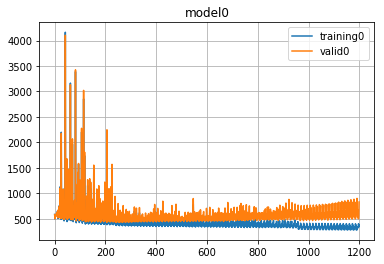

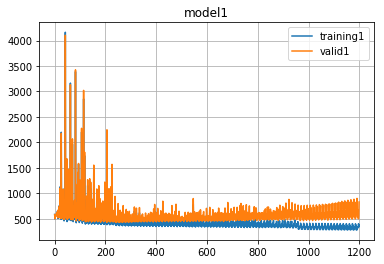

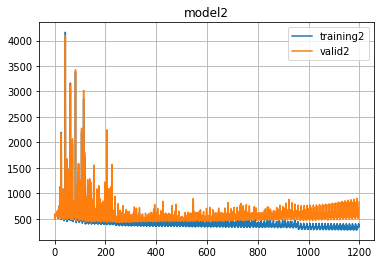

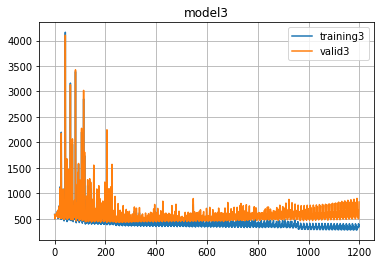

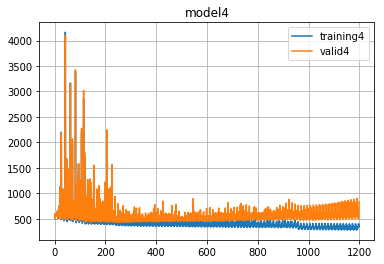

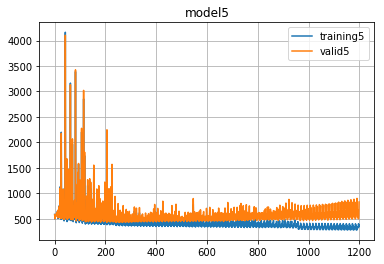

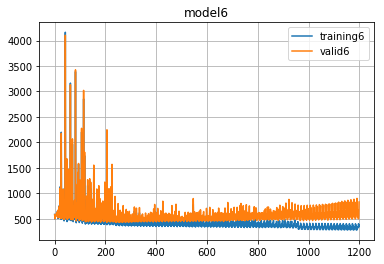

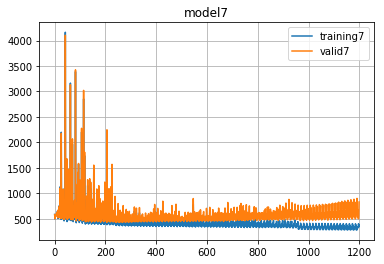

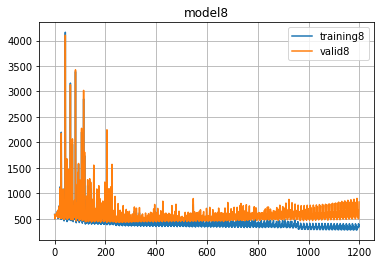

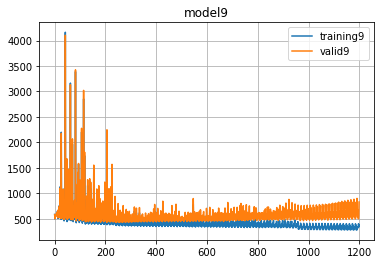

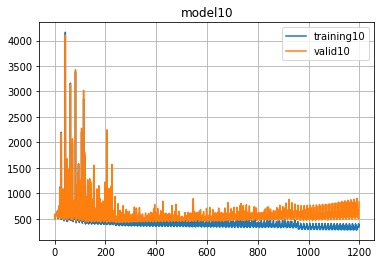

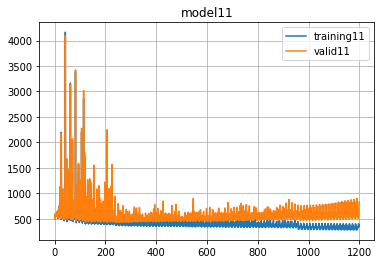

In [26]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

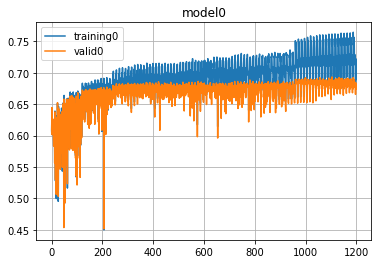

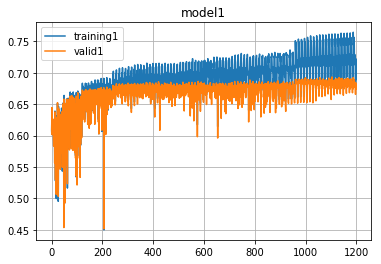

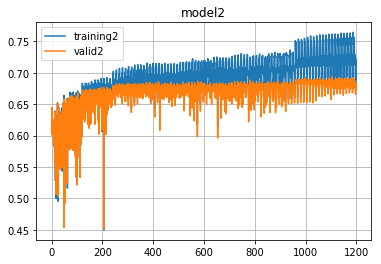

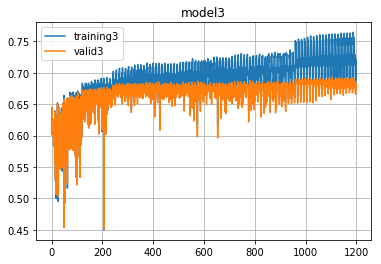

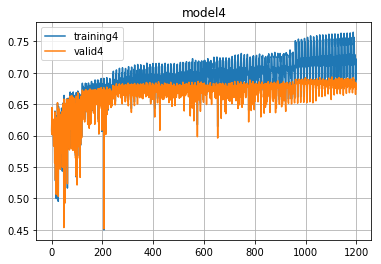

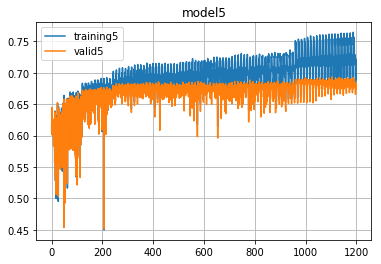

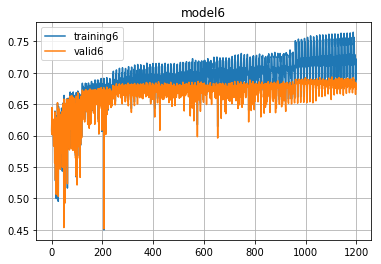

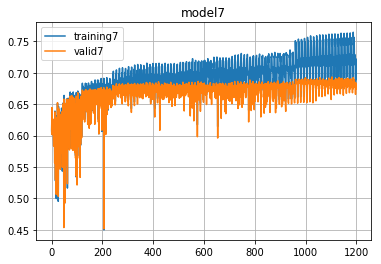

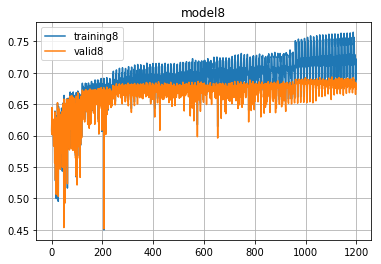

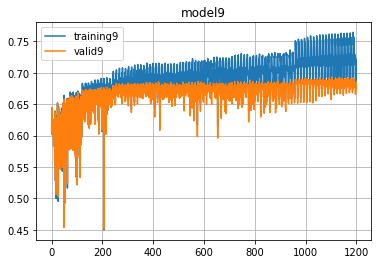

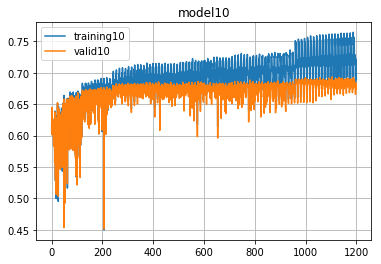

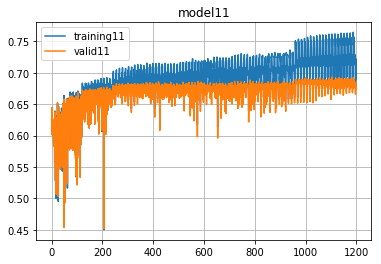

In [27]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

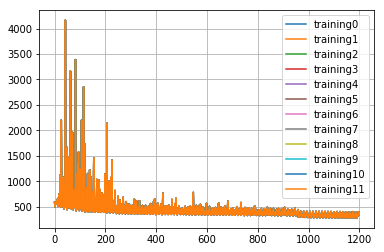

In [28]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

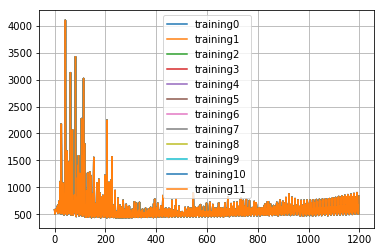

In [29]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

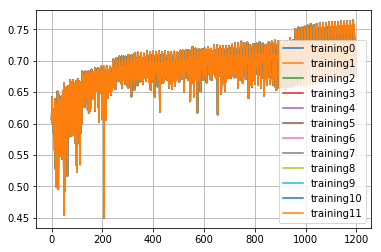

In [30]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

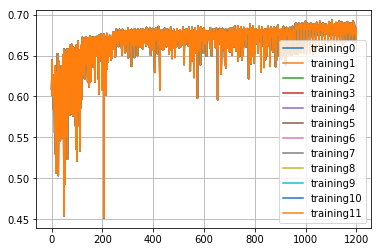

In [31]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

<br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_res_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [45]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)

    total_lst = activity
    return total_lst, label

In [50]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [51]:
print(test_data.shape)

(40000, 304)


<br></br><br></br><br></br> 

# Predict

In [ ]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

In [ ]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()